In [1]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import qutip as quit
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve)
from qutip.measurement import measure_observable, measurement_statistics
from qutip.expect import expect
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
#Add util to the path
import sys
sys.path.append('../util')
sys.path.append('../')

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
#import savgol:
from scipy.signal import savgol_filter
from fitting_functions_ZNE import third_no_first_ZNE, order_poly_ZNE, order_poly_instance, converge_ZNE_order, gaussian_ZNE, converge_ZNE_loocv


from tqdm import tqdm
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve, sesolve, mesolve)
from basic_TFIM_funcs import get_s_lists
from joblib import Parallel, delayed
from functions_util import cetina_thermal_exp, cetina_envelope_exp,calibrate_sim_Omegas
from samplers_util import thermal_rejection

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


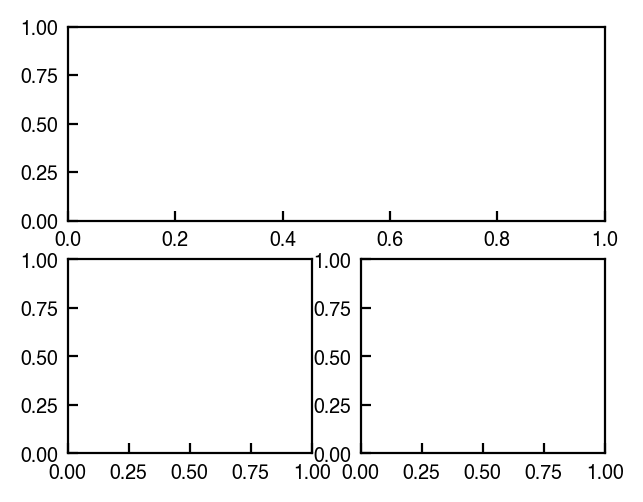

In [2]:
import matplotlib as mpl

columns = 1
rows = 2
#scol=(3+3/8) #single column width of PRL,
#dcol=2*scol # double column,
#size_col = [scol, dcol][columns-1]
#size_row = [scol, dcol][rows-1]
mmtoinch = 1/25.4
scol = 88 * mmtoinch
dcol = 180 * mmtoinch
size_col = [scol, dcol][columns-1]
if columns == 1:
    size_row = scol*rows
else:
    size_row = dcol*rows

fullwidth=6.3,
from matplotlib import cm
gr=(np.sqrt(5.0) - 1.0) / 2.0 #golden ratio,
cm_subsection = np.linspace(0.2, 1.0, 5)
Reds = [ cm.Reds(x) for x in cm_subsection ]
mpl.rcParams.update({
    "ytick.direction": "in",
    "xtick.direction": "in",
    "axes.labelpad": 0,
    "font.size": 7,
    "legend.frameon": True,
    "figure.dpi":200,
    "figure.figsize": [size_col, size_row * gr],
    "font.family": "Helvetica",
    #"axes.prop_cycle": cycler('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)
    # "axes.prop_cycle": cycler('color', palettable.colorbrewer.sequential.Reds_9.mpl_colors[1:])
})
fig = plt.figure()
gs = gridspec.GridSpec(3,2)  # 2x2 grid
ax_a = fig.add_subplot(gs[:2])
ax_bi = fig.add_subplot(gs[2])
ax_bii = fig.add_subplot(gs[3])



In [3]:
#Load in the Rydberg data:
stagmag_averaged = np.load("stagmag_averaged_old.npy")
thetas = np.load("thetas.npy")
thetas = np.power(thetas, 2)
times = np.load("times.npy")
#print(stagmag_averaged.shape)
#print(times.shape)
#indexed as [theta, time] with sizes 100, 500

cmap = cm.get_cmap('Reds', 100)
#only use the range 0.5 - 1
colors = cmap(np.linspace(0.3, 1, 100))
baseline = np.power(0.03,2)
#Get the index in thetas closest to baseline:
baseline_index = np.argmin(np.abs(thetas - baseline))
factors = [1, 1.1, 1.3, 1.6, 2, 2.5, 3]#, 3.5, 4, 4.5, 5]
#factors = np.array([1.0, 1.0810140527710055, 1.3174929343376374, 1.6902785321094298, 2.1691699739962274, 2.71537032345343])

#factors = np.linspace(1, 3, 10)
#Get the indexes of the factors * the baseline
indexes = [np.argmin(np.abs(thetas - baseline*factor)) for factor in factors]
#print([np.abs(thetas - baseline*factor) for factor in factors])
indexes = np.unique(indexes)
#print(baseline)
#print(indexes)
#print(indexes)
indexes_mask = [i in indexes for i in range(len(thetas))]
#print(thetas[indexes_mask])
# print()



#sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(np.array(factors)*baseline)))
#sm.set_array([])
#Add a label to the color bar:
#cbar = fig.colorbar(sm, ax=ax_a)
#ax_a.plot(times, stagmag_averaged[-1], color=colors[-1], label=r"$\theta = {}$".format(thetas[-1]))

/var/folders/vf/9t237r796tb0tg2rrtljdd940000gn/T/ipykernel_86118/3044211753.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds', 100)


In [4]:

def create_linear_function(y_at_0_5):
    # Given points
    x1, y1 = 0.5, y_at_0_5
    x2, y2 = 1, 1
    
    # Calculate slope (a) and intercept (b)
    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1
    
    # Return the linear function
    def linear_function(x):
        return a * x + b
    
    return linear_function

linear_func = create_linear_function(0.5)
#actual_x 
actual_x = baseline * np.array(factors)
normalized_ZNE_points_for_color = linear_func(actual_x/max(actual_x))
#cm_subsection = np.linspace(0.2, 1.0, len(ZNE_points) )
Reds = [ cm.Reds(x) for x in normalized_ZNE_points_for_color ]
cmap = LinearSegmentedColormap.from_list('name', Reds)

colors = Reds#cmap(np.linspace(0, 1, len(ZNE_points)))

colorbar = plt.cm.ScalarMappable(cmap=cmap)

# Add color bar to ax_bii
#test_ticks = normalized_ZNE_points_for_color
test_labels = np.asarray([0.0005,  0.001, 0.0015, 0.002, 0.0025])#np.power(np.array([0.04, 0.05, 0.06, 0.07]),2)
print(max(actual_x))
print(actual_x)
print(baseline)
print(test_labels)
test_ticks = linear_func(test_labels/max(actual_x))
#labels = np.array(['{:.4f}'.format(test_labels[i-1]) for i in range(1,len(ZNE_points))])
print(test_ticks)
#ticks_test = linear_func(test_labels/((max(actual_x))**2))
cbar = plt.colorbar(colorbar, ax=ax_a, ticks=test_ticks)#normalized_ZNE_points_for_color[1:])
cbar.set_ticklabels(test_labels)
print(test_ticks)
print(test_labels/max(actual_x))
#Padd colors so that the the colors[index[i]] corresponds to the correct colors[i] currently. There should be 100 total:
colors_padded = np.zeros((100, 4))
for i in range(len(indexes)):
    colors_padded[indexes[i]] = colors[i]
print(colors_padded)
colors = colors_padded

ax_a.plot(times, stagmag_averaged[0], color='black', label=r"Noiseless", ls="--", zorder=1000)
#Fill between:
error_stats = np.ones(sum(indexes_mask))*1/np.sqrt(10000)

for index in indexes:
    print(colors[index])
    if index == indexes[0]:
        ax_a.plot(times, stagmag_averaged[index], color=colors[index], lw=0.6, zorder=100-index, label='Experimental')
    else:
        ax_a.plot(times, stagmag_averaged[index], color=colors[index], lw=0.6, zorder=100-index)



0.0027
[0.0009  0.00099 0.00117 0.00144 0.0018  0.00225 0.0027 ]
0.0009
[0.0005 0.001  0.0015 0.002  0.0025]
[0.18518519 0.37037037 0.55555556 0.74074074 0.92592593]
[0.18518519 0.37037037 0.55555556 0.74074074 0.92592593]
[0.18518519 0.37037037 0.55555556 0.74074074 0.92592593]
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.

<Figure size 692.913x856.488 with 0 Axes>

In [5]:
#Compute the ZNE data matrix:
ZNE_function = lambda x, y: converge_ZNE_loocv(x, y, debug=False, remove_first=False, return_cov=True, return_order=True)

try: 
    ZNE_data
except:
    ZNE_data = np.zeros(len(times))
    ZNE_cov = np.zeros(len(times))
    ZNE_functions = []
    #indexes_mask=[i > baseline_index for i in range(len(thetas))]
    for i in tqdm(range(len(times))):
        temp_function, error, order = ZNE_function(thetas[indexes_mask], stagmag_averaged[:, i][indexes_mask])#, weights=[1, 1, 1])
        print(order)
        ZNE_data[i] = temp_function(0)
        ZNE_cov[i] = error
        ZNE_functions.append(temp_function)
current_ylims = ax_a.get_ylim()
ax_a.fill_between(times, ZNE_data-ZNE_cov, ZNE_data+ZNE_cov, color="blue", alpha=0.1, zorder=-1)
ax_a.plot(times, ZNE_data, color="blue", label="Zero Noise Extrapolation", zorder=-1, lw=0.6)#, linestyle="--")


  0%|          | 0/500 [00:00<?, ?it/s]/Users/thomassteckmann/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
  0%|          | 1/500 [00:00<01:16,  6.56it/s]

[nan, 0.0, 0.0, 0.0, 0.0, 0.0]
1
[1 0]
[[ 0. -0.]
 [-0.  0.]]
0.0
0.0
1
[nan, 4.46766621402406e-09, 1.0022915293439482e-09, 4.5318099123692844e-09, 4.531371956120007e-09, 4.531371956120007e-09]
2
[1 0 0]
[[ 3.06790999e-10 -3.76697443e-07  1.01752692e-04]
 [-3.76697443e-07  4.82460568e-04 -1.33853642e-01]
 [ 1.01752692e-04 -1.33853642e-01  3.80854026e+01]]
3.075295483419877e-10
1.751545028741196e-05
2
[nan, 4.490317290579338e-08, 2.5952822381209478e-08, 8.866475361936096e-08, 8.867210166407216e-08, 8.867210166407216e-08]
2
[1 0 0]
[[ 7.92740207e-09 -9.73349815e-06  2.62916574e-03]
 [-9.73349815e-06  1.24659880e-02 -3.45853002e+00]
 [ 2.62916574e-03 -3.45853002e+00  9.84050799e+02]]
7.664516790413742e-09
8.903595940020857e-05
2
[nan, 1.9438171194993595e-07, 1.4374016362211685e-07, 4.55269227000678e-07, 4.552147227667004e-07, 4.552147227667004e-07]
2
[1 0 0]
[[ 4.38807987e-08 -5.38804846e-05  1.45542986e-02]
 [-5.38804846e-05  6.90087002e-02 -1.91459155e+01]
 [ 1.45542986e-02 -1.91459155e

  1%|▏         | 7/500 [00:00<00:15, 31.31it/s]

[nan, 5.45058377122168e-07, 4.482069935138256e-07, 1.3684381479756484e-06, 1.3685103281203804e-06, 1.3685103281203804e-06]
2
[1 0 0]
[[ 1.36770788e-07 -1.67936230e-04  4.53628688e-02]
 [-1.67936230e-04  2.15084890e-01 -5.96730363e+01]
 [ 4.53628688e-02 -5.96730363e+01  1.69786741e+04]]
1.310137575392858e-07
0.00036982534770866113
2
[nan, 1.174382074242456e-06, 1.0234218589929963e-06, 3.056373296637276e-06, 3.0562679248299605e-06, 3.0562679248299605e-06]
2
[1 0 0]
[[ 3.12233859e-07 -3.83382521e-04  1.03559437e-01]
 [-3.83382521e-04  4.91018714e-01 -1.36228147e+02]
 [ 1.03559437e-01 -1.36228147e+02  3.87607701e+04]]
2.986444933511363e-07
0.0005587788998431202
2
[nan, 2.1180232290747436e-06, 1.914309049455888e-06, 5.6380949316718045e-06, 5.638130946761528e-06, 5.638130946761528e-06]
2
[1 0 0]
[[ 5.83949797e-07 -7.17013624e-04  1.93679942e-01]
 [-7.17013624e-04  9.18318395e-01 -2.54778223e+02]
 [ 1.93679942e-01 -2.54778223e+02  7.24917206e+04]]
5.577823965472289e-07
0.0007641660792767725
2

  3%|▎         | 14/500 [00:00<00:10, 46.02it/s]

[nan, 1.3708692260646423e-05, 1.3301189459527189e-05, 3.749195401358867e-05, 3.749172480831289e-05, 3.749172480831289e-05]
2
[1 0 0]
[[ 4.05199635e-06 -4.97530715e-03  1.34392816e+00]
 [-4.97530715e-03  6.37213051e+00 -1.76787928e+03]
 [ 1.34392816e+00 -1.76787928e+03  5.03011235e+05]]
3.877895543235287e-06
0.002012957114647722
2
[nan, 1.5347600944712355e-05, 1.4932766556331534e-05, 4.177349855889713e-05, 4.177375532458751e-05, 4.177375532458751e-05]
2
[1 0 0]
[[ 4.54607058e-06 -5.58196430e-03  1.50779817e+00]
 [-5.58196430e-03  7.14910884e+00 -1.98344377e+03]
 [ 1.50779817e+00 -1.98344377e+03  5.64345471e+05]]
4.362329107778032e-06
0.0021321516310273416
2
[nan, 1.672976686097083e-05, 1.6344777420669992e-05, 4.5240613486572416e-05, 4.5241380803032224e-05, 4.5241380803032224e-05]
2
[1 0 0]
[[ 4.97105913e-06 -6.10378507e-03  1.64875039e+00]
 [-6.10378507e-03  7.81741470e+00 -2.16885468e+03]
 [ 1.64875039e+00 -2.16885468e+03  6.17098918e+05]]
4.791498082715524e-06
0.0022295872098072158
2


  4%|▍         | 21/500 [00:00<00:09, 51.62it/s]

[nan, 1.3246959481116227e-05, 1.3796522604526463e-05, 3.338050974953728e-05, 3.33807017478404e-05, 3.33807017478404e-05]
1
[1 0]
[[ 3.88038156e-07 -2.11918299e-04]
 [-2.11918299e-04  1.33532750e-01]]
3.3701227570600124e-07
0.0006229270875127105
1
[nan, 9.964460198782481e-06, 1.0671542298467615e-05, 2.3926007392574245e-05, 2.392571876035741e-05, 2.392571876035741e-05]
1
[1 0]
[[ 2.92469440e-07 -1.59725581e-04]
 [-1.59725581e-04  1.00645369e-01]]
2.397711433941741e-07
0.0005408044375621687
1
[nan, 6.413617845985519e-06, 7.137477068159128e-06, 1.4014260851493199e-05, 1.4014396452078977e-05, 1.4014396452078977e-05]
1
[1 0]
[[ 1.88410733e-07 -1.02896320e-04]
 [-1.02896320e-04  6.48364621e-02]]
1.4555221785713122e-07
0.0004340630520559614
1
[nan, 3.2300860072024684e-06, 3.7705428696470333e-06, 5.588639268447994e-06, 5.588220504435085e-06, 5.588220504435085e-06]
1
[1 0]
[[ 9.42243836e-08 -5.14585524e-05]
 [-5.14585524e-05  3.24247815e-02]]
7.546453112495679e-08
0.0003069599055229999
1
[nan, 1

  6%|▌         | 28/500 [00:00<00:08, 55.29it/s]

7.357866689928076e-07
0.0007510044803148476
2
[nan, 8.153108499820546e-06, 6.097629960470301e-06, 2.3524517697604668e-05, 2.352405343758734e-05, 2.352405343758734e-05]
2
[1 0 0]
[[ 1.84965373e-06 -2.27112392e-03  6.13474168e-01]
 [-2.27112392e-03  2.90874200e+00 -8.06998050e+02]
 [ 6.13474168e-01 -8.06998050e+02  2.29613258e+05]]
1.7601361909215889e-06
0.0013600197549065573
2
[nan, 1.5580371675980408e-05, 1.2790371958848882e-05, 4.505091885382686e-05, 4.504939335987681e-05, 4.504939335987681e-05]
2
[1 0 0]
[[ 3.93506847e-06 -4.83173225e-03  1.30514485e+00]
 [-4.83173225e-03  6.18824147e+00 -1.71685986e+03]
 [ 1.30514485e+00 -1.71685986e+03  4.88494356e+05]]
3.5464381921521742e-06
0.00198370070112044
2
[nan, 2.5162501202734474e-05, 2.179687734922919e-05, 7.224223428234448e-05, 7.224110163654601e-05, 7.224110163654601e-05]
2
[1 0 0]
[[ 6.71866327e-06 -8.24961211e-03  2.22838262e+00]
 [-8.24961211e-03  1.05656904e+01 -2.93133713e+03]
 [ 2.22838262e+00 -2.93133713e+03  8.34047313e+05]]
6.0

  8%|▊         | 42/500 [00:00<00:07, 59.67it/s]

[nan, 8.150686002266099e-05, 7.84117521147213e-05, 0.00022231777567163476, 0.0002223185081452668, 0.0002223185081452668]
2
[1 0 0]
[[ 2.39464953e-05 -2.94030832e-02  7.94235187e+00]
 [-2.94030832e-02  3.76580425e+01 -1.04478229e+04]
 [ 7.94235187e+00 -1.04478229e+04  2.97269953e+06]]
2.2593535358658035e-05
0.004893515634024694
2
[nan, 9.008519696140583e-05, 8.748371834034797e-05, 0.0002436571342423224, 0.00024365637597186727, 0.00024365637597186727]
2
[1 0 0]
[[ 2.66615358e-05 -3.27367932e-02  8.84285265e+00]
 [-3.27367932e-02  4.19276940e+01 -1.16323907e+04]
 [ 8.84285265e+00 -1.16323907e+04  3.30974157e+06]]
2.540237911470173e-05
0.005163480973358092
2
[nan, 9.683512905289061e-05, 9.483747144372179e-05, 0.0002593138444205601, 0.0002593138444205601, 0.0002593138444205601]
2
[1 0 0]
[[ 2.88392983e-05 -3.54107792e-02  9.56514606e+00]
 [-3.54107792e-02  4.53523974e+01 -1.25825364e+04]
 [ 9.56514606e+00 -1.25825364e+04  3.58008477e+06]]
2.7752050754193265e-05
0.005370223296539879
2
[nan, 

 10%|▉         | 49/500 [00:00<00:07, 61.65it/s]

[nan, 2.0233770204411456e-05, 2.159967193280132e-05, 2.0337785160182803e-05, 2.0337940288345553e-05, 2.0337940288345553e-05]
1
[1 0]
[[ 5.67065884e-07 -3.09690361e-04]
 [-3.09690361e-04  1.95140385e-01]]
7.142647282069628e-07
0.0007530377707483807
1
[nan, 1.278879328209269e-05, 1.0697088235898007e-05, 4.897835433665275e-06, 4.897835435708129e-06, 4.897835435708129e-06]
3
[1 0 0 0]
[[ 2.49543630e-05 -4.88304018e-02  2.91117020e+01 -5.36214878e+03]
 [-4.88304018e-02  9.67406752e+01 -5.82440092e+04  1.08077251e+07]
 [ 2.91117020e+01 -5.82440092e+04  3.53905187e+07 -6.61643551e+09]
 [-5.36214878e+03  1.08077251e+07 -6.61643551e+09  1.24510753e+12]]
2.679850216639125e-05
0.0049954342179819354
3


/Users/thomassteckmann/Duke_Analog_ZNE_data/Figures/../util/fitting_functions_ZNE.py:308: RuntimeWarning: invalid value encountered in matmul
  sigma_0 = np.sqrt(J @ cov @ J.T)
 11%|█         | 56/500 [00:01<00:07, 63.18it/s]

[nan, 1.0294827861052426e-05, 4.864421305174655e-06, 3.875930376707008e-06, 3.875577806749686e-06, 3.875577806749686e-06]
4
[1 0 0 0 0]
[[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]]
2.144019958980598e-05
nan
4
[nan, 1.3310604874534683e-05, 5.2498199947198616e-06, 1.8620004248157356e-05, 1.862000423073803e-05, 1.862000423073803e-05]
2
[1 0 0]
[[ 1.03210606e-06 -1.26728729e-03  3.42319128e-01]
 [-1.26728729e-03  1.62308013e+00 -4.50306250e+02]
 [ 3.42319128e-01 -4.50306250e+02  1.28124813e+05]]
3.2363085487456676e-06
0.0010159262087282683
2
[nan, 2.186254562689508e-05, 1.215859250605265e-05, 4.861108514862179e-05, 4.861108514862179e-05, 4.861108514862179e-05]
2
[1 0 0]
[[ 3.38761969e-06 -4.15954379e-03  1.12357489e+00]
 [-4.15954379e-03  5.32734155e+00 -1.47801406e+03]
 [ 1.12357489e+00 -1.47801406e+03  4.20536443e+05]]
4.391263374150408e-06
0.0018405487477822918
2
[nan, 3.536180966736891e-05, 2.5052738768461052e-05, 9

 14%|█▍        | 70/500 [00:01<00:07, 57.67it/s]


2
[1 0 0]
[[ 5.02863386e-05 -6.17448632e-02  1.66784989e+01]
 [-6.17448632e-02  7.90798067e+01 -2.19398440e+04]
 [ 1.66784989e+01 -2.19398440e+04  6.24250108e+06]]
4.7661227294490016e-05
0.007091286100348617
2
[nan, 0.00018395115740251096, 0.00018013779699943682, 0.0004770443036176131, 0.0004770443036176131, 0.0004770443036176131]
2
[1 0 0]
[[ 5.47127175e-05 -6.71798539e-02  1.81465957e+01]
 [-6.71798539e-02  8.60406706e+01 -2.38710607e+04]
 [ 1.81465957e+01 -2.38710607e+04  6.79198646e+06]]
5.278133136914345e-05
0.007396804548371419
2
[nan, 0.00019547403000145288, 0.0001932267749620103, 0.0004918184099589197, 0.0004918211165223792, 0.0004918211165223792]
2
[1 0 0]
[[ 5.84189319e-05 -7.17306056e-02  1.93758477e+01]
 [-7.17306056e-02  9.18690852e+01 -2.54880993e+04]
 [ 1.93758477e+01 -2.54880993e+04  7.25208171e+06]]
5.74759966347343e-05
0.007643227845739119
2
[nan, 0.0002034674703961076, 0.00020390402028166115, 0.0004953091308516964, 0.0004953108674781259, 0.0004953108674781259]
1
[1 

 17%|█▋        | 84/500 [00:01<00:06, 61.83it/s]


0.0023827027754355157
2
[nan, 7.060747137091247e-05, 4.2229716340266434e-05, 0.00014565752816705734, 0.0001456569696919965, 0.0001456569696919965]
2
[1 0 0]
[[ 1.23059485e-05 -1.51100456e-02  4.08151907e+00]
 [-1.51100456e-02  1.93522049e+01 -5.36906117e+03]
 [ 4.08151907e+00 -5.36906117e+03  1.52764851e+06]]
1.3370382939999745e-05
0.003507983538008761
2
[nan, 9.434780486436612e-05, 7.032894925738433e-05, 0.00022772976844110085, 0.00022772866796313767, 0.00022772866796313767]
2
[1 0 0]
[[ 2.13791329e-05 -2.62506950e-02  7.09082743e+00]
 [-2.62506950e-02  3.36206048e+01 -9.32767648e+03]
 [ 7.09082743e+00 -9.32767648e+03  2.65398592e+06]]
1.9711349134876352e-05
0.004623757446106439
2
[nan, 0.0001238680328649529, 0.00010424424003208163, 0.0003182343351151401, 0.000318229865827637, 0.000318229865827637]
2
[1 0 0]
[[ 3.20892442e-05 -3.94012723e-02  1.06430553e+01]
 [-3.94012723e-02  5.04632187e+01 -1.40004769e+04]
 [ 1.06430553e+01 -1.40004769e+04  3.98352791e+06]]
2.8239064183439266e-05
0

 22%|██▏       | 108/500 [00:01<00:05, 70.97it/s]

[nan, 0.0002816499374705967, 0.00029081972188475813, 0.00040593734875921973, 0.00040593747577235054, 0.00040593747577235054]
1
[1 0]
[[ 8.07707820e-06 -4.41111580e-03]
 [-4.41111580e-03  2.77950798e+00]]
7.573301173603665e-06
0.002842020090540558
1
[nan, 0.00025848230980731704, 0.00024350155369430633, 0.0003133385576423838, 0.0003133385613856617, 0.0003133385613856617]
2
[1 0 0]
[[ 6.67815392e-05 -8.19987438e-02  2.21494664e+01]
 [-8.19987438e-02  1.05019987e+02 -2.91366664e+04]
 [ 2.21494664e+01 -2.91366664e+04  8.29019871e+06]]
9.300780884844678e-05
0.008171997258630683
2
[nan, 0.0002313835753535331, 0.00019107770142678818, 0.00022190204344033093, 0.00022190731112972585, 0.00022190731112972585]
2
[1 0 0]
[[ 5.10494809e-05 -6.26819066e-02  1.69316129e+01]
 [-6.26819066e-02  8.02799333e+01 -2.22728062e+04]
 [ 1.69316129e+01 -2.22728062e+04  6.33723799e+06]]
7.74552541036343e-05
0.007144891943391349
2
[nan, 0.0002003050288302647, 0.00013863137700318579, 0.00013883419995286232, 0.0001388

 25%|██▍       | 124/500 [00:02<00:05, 70.24it/s]

[nan, 0.00037609519580659415, 0.00040995308710842064, 0.0007323825258349886, 0.000732382450328352, 0.000732382450328352]
1
[1 0]
[[ 1.10594150e-05 -6.03985259e-03]
 [-6.03985259e-03  3.80579874e+00]]
8.157270462304728e-06
0.0033255698730194844
1
[nan, 0.00038588319686740384, 0.00042926934523064884, 0.0007181321665992683, 0.000718134495778131, 0.000718134495778131]
1
[1 0]
[[ 1.13523708e-05 -6.19984370e-03]
 [-6.19984370e-03  3.90661133e+00]]
7.825258399404664e-06
0.0033693279377493826
1
[nan, 0.0003911452811369583, 0.00043686035522611487, 0.0006864974049548415, 0.000686497173206108, 0.000686497173206108]
1
[1 0]
[[ 1.14782425e-05 -6.26858583e-03]
 [-6.26858583e-03  3.94992682e+00]]
7.795004369995596e-06
0.003387955503967341
1
[nan, 0.0003941679107626083, 0.00043095851645234145, 0.0006385440853383828, 0.0006385392403179117, 0.0006385392403179117]
1
[1 0]
[[ 1.14889226e-05 -6.27441853e-03]
 [-6.27441853e-03  3.95360211e+00]]
8.414282285486979e-06
0.0033895313246034586
1
[nan, 0.000396066

 28%|██▊       | 140/500 [00:02<00:05, 71.83it/s]

[nan, 0.0002839539831989618, 0.00026111717074378657, 0.0005090867568144892, 0.0005090858382705712, 0.0005090858382705712]
2
[1 0 0]
[[ 7.91762956e-05 -9.72178377e-02  2.62604445e+01]
 [-9.72178377e-02  1.24511853e+02 -3.45444776e+04]
 [ 2.62604445e+01 -3.45444776e+04  9.82887305e+06]]
7.392871889375796e-05
0.008898106292866564
2
[nan, 0.00032386267734931396, 0.00032297259365759263, 0.0005902026664106449, 0.0005902015551248515, 0.0005902015551248515]
2
[1 0 0]
[[ 9.68528188e-05 -1.18922249e-01  3.21232347e+01]
 [-1.18922249e-01  1.52309830e+02 -4.22567328e+04]
 [ 3.21232347e+01 -4.22567328e+04  1.20232274e+07]]
9.511805780664778e-05
0.009841382970266415
2
[nan, 0.0003619522205834006, 0.0003824976882242196, 0.0006575668769919648, 0.0006575668769919648, 0.0006575668769919648]
1
[1 0]
[[ 1.06367909e-05 -5.80904573e-03]
 [-5.80904573e-03  3.66036391e+00]]
7.82779543657071e-06
0.0032614093392293606
1
[nan, 0.0003981690154547334, 0.0004354731729821956, 0.0007083664409508233, 0.000708366581407

 31%|███▏      | 157/500 [00:02<00:05, 64.66it/s]

[nan, 0.0002564451583482377, 3.4853804924178485e-05, 3.760170120831036e-06, 3.760170120831036e-06, 3.760170120831036e-06]
3
[1 0 0 0]
[[ 1.63662472e-05 -3.20253103e-02  1.90928720e+01 -3.51676251e+03]
 [-3.20253103e-02  6.34472283e+01 -3.81993042e+04  7.08824972e+06]
 [ 1.90928720e+01 -3.81993042e+04  2.32108897e+07 -4.33939797e+09]
 [-3.51676251e+03  7.08824972e+06 -4.33939797e+09  8.16606430e+11]]
2.107263905203122e-05
0.004045521874262327
3
[nan, 0.00021040343866148594, 2.2826481822250922e-05, 3.039096257093971e-06, 3.039096257093971e-06, 3.039096257093971e-06]
3
[1 0 0 0]
[[ 6.11817647e-06 -1.19719917e-02  7.13747337e+00 -1.31466905e+03]
 [-1.19719917e-02  2.37184279e+01 -1.42800223e+04  2.64979704e+06]
 [ 7.13747337e+00 -1.42800223e+04  8.67691652e+06 -1.62219583e+09]
 [-1.31466905e+03  2.64979704e+06 -1.62219583e+09  3.05271854e+11]]
1.8499649453533196e-05
0.00247349478871083
3
[nan, 0.0001811015132431488, 2.4396094251717614e-05, 2.491090878289561e-05, 2.4910908782904622e-05, 2.4

 35%|███▍      | 174/500 [00:02<00:04, 71.90it/s]

[nan, 0.00043373834977401056, 0.0004534153796172721, 0.0006208922486730848, 0.0006208912635860714, 0.0006208912635860714]
1
[1 0]
[[ 1.26183634e-05 -6.89123753e-03]
 [-6.89123753e-03  4.34226873e+00]]
8.956861729137801e-06
0.0035522335825491857
1
[nan, 0.0004889898112385572, 0.00047354115085050457, 0.0006317915674571298, 0.0006317913250934168, 0.0006317913250934168]
2
[1 0 0]
[[ 1.37699009e-04 -1.69075875e-01  4.56707134e+01]
 [-1.69075875e-01  2.16544137e+02 -6.00778516e+04]
 [ 4.56707134e+01 -6.00778516e+04  1.70938352e+07]]
0.00015128905656452518
0.011734522097332986
2
[nan, 0.000549237596413156, 0.0004791969343814438, 0.0006252840360274066, 0.0006252840383417487, 0.0006252840383417487]
2
[1 0 0]
[[ 1.38905324e-04 -1.70557045e-01  4.60708030e+01]
 [-1.70557045e-01  2.18441119e+02 -6.06041452e+04]
 [ 4.60708030e+01 -6.06041452e+04  1.72435798e+07]]
0.0001544063769142079
0.011785810267027592
2
[nan, 0.0006108194919960731, 0.00047006170568028165, 0.000601738667501964, 0.000601738671898

 38%|███▊      | 191/500 [00:02<00:04, 75.03it/s]

1.533254847554614e-05
0.004328597472938689
2
[nan, 0.00024210004873504297, 0.00010332166981402191, 0.00013431072383701263, 0.00013431072383701263, 0.00013431072383701263]
2
[1 0 0]
[[ 3.16905465e-05 -3.89117272e-02  1.05108204e+01]
 [-3.89117272e-02  4.98362369e+01 -1.38265288e+04]
 [ 1.05108204e+01 -1.38265288e+04  3.93403521e+06]]
2.7120780715729076e-05
0.0056294357213829745
2
[nan, 0.00022914077206617625, 0.00015480322330213152, 0.0001987973160323127, 0.00019879811229125505, 0.00019879811229125505]
2
[1 0 0]
[[ 4.69978021e-05 -5.77069750e-02  1.55877855e+01]
 [-5.77069750e-02  7.39082705e+01 -2.05050568e+04]
 [ 1.55877855e+01 -2.05050568e+04  5.83426406e+06]]
4.2351699124019664e-05
0.006855494299612743
2
[nan, 0.00023245043041642823, 0.0002112004844387947, 0.00026789129516653225, 0.0002678918674448889, 0.0002678918674448889]
2
[1 0 0]
[[ 6.36152268e-05 -7.81109371e-02  2.10992948e+01]
 [-7.81109371e-02  1.00040667e+02 -2.77552084e+04]
 [ 2.10992948e+01 -2.77552084e+04  7.89713512e+0

 41%|████▏     | 207/500 [00:03<00:03, 73.68it/s]

[nan, 0.0007930819224068324, 0.00010816620925238211, 0.00014084861108982447, 0.00014084861108982447, 0.00014084861108982447]
2
[1 0 0]
[[ 2.79175232e-05 -3.42789618e-02  9.25941984e+00]
 [-3.42789618e-02  4.39028174e+01 -1.21803656e+04]
 [ 9.25941984e+00 -1.21803656e+04  3.46565570e+06]]
4.8945782505401906e-05
0.005283703547391327
2
[nan, 0.0007046530132560885, 6.749900677869512e-05, 8.908762597614358e-05, 8.908762597614358e-05, 8.908762597614358e-05]
2
[1 0 0]
[[ 1.64686372e-05 -2.02212703e-02  5.46216160e+00]
 [-2.02212703e-02  2.58984138e+01 -7.18523693e+03]
 [ 5.46216160e+00 -7.18523693e+03  2.04440146e+06]]
3.439914236113084e-05
0.004058156867366178
2
[nan, 0.0006126516122520998, 3.6073825559929424e-05, 4.8873593709285746e-05, 4.8873593709285746e-05, 4.8873593709285746e-05]
2
[1 0 0]
[[ 7.98142946e-06 -9.80012106e-03  2.64720483e+00]
 [-9.80012106e-03  1.25515154e+01 -3.48228320e+03]
 [ 2.64720483e+00 -3.48228320e+03  9.90807252e+05]]
2.175070328387784e-05
0.0028251423780165995
2


 45%|████▍     | 224/500 [00:03<00:03, 74.61it/s]

[1 0 0]
[[ 9.66432693e-05 -1.18664935e-01  3.20537264e+01]
 [-1.18664935e-01  1.51980250e+02 -4.21652900e+04]
 [ 3.20537264e+01 -4.21652900e+04  1.19972080e+07]]
9.958208005641672e-05
0.009830730860995292
2
[nan, 0.001072932620433138, 0.0002955445680092576, 0.00036473929658957093, 0.00036473929658957093, 0.00036473929658957093]
2
[1 0 0]
[[ 8.69223133e-05 -1.06728904e-01  2.88295701e+01]
 [-1.06728904e-01  1.36693160e+02 -3.79240505e+04]
 [ 2.88295701e+01 -3.79240505e+04  1.07904563e+07]]
9.153443693652755e-05
0.009323213680021307
2
[nan, 0.0011292979718812188, 0.000256443233034809, 0.0003246595396410235, 0.0003246595396410311, 0.0003246595396410311]
2
[1 0 0]
[[ 7.50789507e-05 -9.21868486e-02  2.49014755e+01]
 [-9.21868486e-02  1.18068407e+02 -3.27568123e+04]
 [ 2.49014755e+01 -3.27568123e+04  9.32023202e+06]]
8.109356975274912e-05
0.008664811060164415
2
[nan, 0.0011558886840600197, 0.00021257904113929557, 0.00027854386593240767, 0.00027854386593256976, 0.00027854386593256976]
2
[1 0 

 48%|████▊     | 240/500 [00:03<00:03, 75.31it/s]

[nan, 0.00017915452191245238, 0.00018621278111382163, 0.0001943276003687135, 0.00019432760036871356, 0.00019432760036871356]
1
[1 0]
[[ 5.28007901e-06 -2.88359724e-03]
 [-2.88359724e-03  1.81699643e+00]]
2.255631507098787e-06
0.0022978422516038775
1
[nan, 0.00024852992952907626, 0.00021995499873978525, 0.00023246014978280897, 0.00023246014978009098, 0.00023246014978009098]
2
[1 0 0]
[[ 6.70052495e-05 -8.22734308e-02  2.22236673e+01]
 [-8.22734308e-02  1.05371787e+02 -2.92342720e+04]
 [ 2.22236673e+01 -2.92342720e+04  8.31797065e+06]]
5.921604818037463e-05
0.008185673431012688
2
[nan, 0.00034865082555849905, 0.0002492046448970296, 0.0002674420348954602, 0.0002674420494347535, 0.00026744204763496054]
2
[1 0 0]
[[ 7.58796847e-05 -9.31700440e-02  2.51670564e+01]
 [-9.31700440e-02  1.19327637e+02 -3.31061726e+04]
 [ 2.51670564e+01 -3.31061726e+04  9.41963491e+06]]
6.718034984459653e-05
0.008710894598651148
2
[nan, 0.00047211212863544237, 0.0002721169939265896, 0.00029702583049227946, 0.0002

 51%|█████▏    | 257/500 [00:03<00:03, 77.32it/s]

[nan, 0.0007291048415597293, 6.962548435208257e-06, 5.678290804213513e-05, 5.678290804213513e-05, 5.678290804213513e-05]
2
[1 0 0]
[[ 1.95376217e-06 -2.39895707e-03  6.48005358e-01]
 [-2.39895707e-03  3.07246690e+00 -8.52422981e+02]
 [ 6.48005358e-01 -8.52422981e+02  2.42538254e+05]]
4.123769889155315e-06
0.0013977704277834473
2
[nan, 0.0005984340240232602, 3.7231045667038495e-06, 4.630510337907743e-05, 4.630510337907743e-05, 4.630510337907743e-05]
2
[1 0 0]
[[ 1.05818534e-06 -1.29930919e-03  3.50968890e-01]
 [-1.29930919e-03  1.66409166e+00 -4.61684372e+02]
 [ 3.50968890e-01 -4.61684372e+02  1.31362156e+05]]
2.8324727716625847e-06
0.001028681359681249
2
[nan, 0.0004707005049304058, 7.927732869196003e-06, 4.2789069582220844e-05, 4.2789069582220844e-05, 4.2789069582220844e-05]
2
[1 0 0]
[[ 2.36698658e-06 -2.90634101e-03  7.85059704e-01]
 [-2.90634101e-03  3.72229942e+00 -1.03271203e+03]
 [ 7.85059704e-01 -1.03271203e+03  2.93835548e+05]]
3.739111280454388e-06
0.0015385014063238986
2
[na

 55%|█████▍    | 274/500 [00:04<00:03, 65.21it/s]

[nan, 0.0012250566773830019, 0.00018367811275627255, 0.00022435460780532472, 0.00022435460780532472, 0.00022435460780532472]
2
[1 0 0]
[[ 5.63451378e-05 -6.91842492e-02  1.86880227e+01]
 [-6.91842492e-02  8.86078042e+01 -2.45832846e+04]
 [ 1.86880227e+01 -2.45832846e+04  6.99463415e+06]]
4.861902617227772e-05
0.007506339839558082
2
[nan, 0.0013063639434554568, 0.00015813296877342935, 0.00020394340490478575, 0.00020394340490478575, 0.00020394340490478575]
2
[1 0 0]
[[ 4.85475384e-05 -5.96098454e-02  1.61017883e+01]
 [-5.96098454e-02  7.63453755e+01 -2.11812053e+04]
 [ 1.61017883e+01 -2.11812053e+04  6.02664716e+06]]
4.180503618456634e-05
0.006967606363940421
2
[nan, 0.0013525328369540384, 0.000130413112097153, 0.00018117656311507043, 0.00018117656311507043, 0.00018117656311507043]
2
[1 0 0]
[[ 4.00733161e-05 -4.92046408e-02  1.32911387e+01]
 [-4.92046408e-02  6.30188992e+01 -1.74839178e+04]
 [ 1.32911387e+01 -1.74839178e+04  4.97466526e+06]]
3.450811303667479e-05
0.006330348811944162
2


 58%|█████▊    | 290/500 [00:04<00:02, 71.00it/s]

4.399176585058755e-06
0.001399699975065081
2
[nan, 0.00041427662904543286, 1.4559241096394777e-05, 6.569721856335565e-05, 6.569721856335687e-05, 6.569721856335687e-05]
2
[1 0 0]
[[ 4.30696444e-06 -5.28837280e-03  1.42849320e+00]
 [-5.28837280e-03  6.77308921e+00 -1.87912091e+03]
 [ 1.42849320e+00 -1.87912091e+03  5.34662614e+05]]
6.491729312708974e-06
0.0020753227325887333
2
[nan, 0.0002861537103125944, 2.7366480422463153e-05, 7.158826243053944e-05, 7.158826243053944e-05, 7.158826243053944e-05]
2
[1 0 0]
[[ 8.25426944e-06 -1.01351324e-02  2.73769805e+00]
 [-1.01351324e-02  1.29805822e+01 -3.60132329e+03]
 [ 2.73769805e+00 -3.60132329e+03  1.02467753e+06]]
9.818101842930507e-06
0.0028730244417804994
2
[nan, 0.0001862478442544153, 4.465684429926036e-05, 8.157122202573429e-05, 8.157122202573429e-05, 8.157122202573429e-05]
2
[1 0 0]
[[ 1.35955158e-05 -1.66934641e-02  4.50923210e+00]
 [-1.66934641e-02  2.13801726e+01 -5.93169955e+03]
 [ 4.50923210e+00 -5.93169955e+03  1.68773495e+06]]
1.422

 62%|██████▏   | 308/500 [00:04<00:02, 76.27it/s]

[nan, 0.0013903416245486422, 6.979604520814586e-05, 0.0001213734295534841, 0.0001213734295534841, 0.0001213734295534841]
2
[1 0 0]
[[ 2.14992507e-05 -2.63981873e-02  7.13066805e+00]
 [-2.63981873e-02  3.38095078e+01 -9.38008514e+03]
 [ 7.13066805e+00 -9.38008514e+03  2.66889738e+06]]
1.8947608120128134e-05
0.004636728445727693
2
[nan, 0.0013401787054071793, 5.0767569469690896e-05, 0.00010884240774724249, 0.00010884240774724249, 0.00010884240774724249]
2
[1 0 0]
[[ 1.55544025e-05 -1.90987137e-02  5.15893720e+00]
 [-1.90987137e-02  2.44606991e+01 -6.78635858e+03]
 [ 5.15893720e+00 -6.78635858e+03  1.93090942e+06]]
1.4433461266976802e-05
0.0039439070039811825
2
[nan, 0.0012555079476388533, 3.441015317687442e-05, 9.787176001001557e-05, 9.787176001001557e-05, 9.787176001001557e-05]
2
[1 0 0]
[[ 1.04136637e-05 -1.27865779e-02  3.45390549e+00]
 [-1.27865779e-02  1.63764238e+01 -4.54346313e+03]
 [ 3.45390549e+00 -4.54346313e+03  1.29274275e+06]]
1.0660833996853084e-05
0.003227020869976609
2
[n

 65%|██████▌   | 325/500 [00:04<00:02, 78.84it/s]

[1 0 0]
[[ 5.12938936e-05 -6.29819990e-02  1.70126730e+01]
 [-6.29819990e-02  8.06642642e+01 -2.23794346e+04]
 [ 1.70126730e+01 -2.23794346e+04  6.36757705e+06]]
4.535479160757711e-05
0.007161975536337074
2
[nan, 0.0009912628265630109, 0.00016404325337286867, 0.0001727197989572835, 0.0001727197989572835, 0.0001727197989572835]
2
[1 0 0]
[[ 5.03934299e-05 -6.18763506e-02  1.67140156e+01]
 [-6.18763506e-02  7.92482040e+01 -2.19865639e+04]
 [ 1.67140156e+01 -2.19865639e+04  6.25579430e+06]]
4.470767840600901e-05
0.007098832996049192
2
[nan, 0.0011777467793347945, 0.00015681975438885538, 0.00016474044371160074, 0.00016474044371160074, 0.00016474044371160074]
2
[1 0 0]
[[ 4.80424345e-05 -5.89896464e-02  1.59342607e+01]
 [-5.89896464e-02  7.55510559e+01 -2.09608302e+04]
 [ 1.59342607e+01 -2.09608302e+04  5.96394434e+06]]
4.296925136364227e-05
0.006931264997609924
2
[nan, 0.0013462484717439121, 0.00014568037461523353, 0.00015445151037671412, 0.00015445151037671412, 0.00015445151037671412]
2
[

 68%|██████▊   | 341/500 [00:04<00:02, 79.33it/s]

3.163972792862836e-05
0.0056162126668174725
2
[nan, 0.00017347006128076944, 0.00012139249753598681, 0.00017141512298966222, 0.0001714150419405683, 0.0001714150416081789]
2
[1 0 0]
[[ 3.72074423e-05 -4.56857330e-02  1.23406127e+01]
 [-4.56857330e-02  5.85120532e+01 -1.62335416e+04]
 [ 1.23406127e+01 -1.62335416e+04  4.61889811e+06]]
3.686808002005119e-05
0.006099790346785741
2
[nan, 0.00029298860451007887, 0.00013748680406903242, 0.00018014772901524533, 0.00018014774052101448, 0.00018014788518070756]
2
[1 0 0]
[[ 4.20591442e-05 -5.16429700e-02  1.39497792e+01]
 [-5.16429700e-02  6.61417906e+01 -1.83503304e+04]
 [ 1.39497792e+01 -1.83503304e+04  5.22118390e+06]]
4.149078673104565e-05
0.0064853021655330075
2
[nan, 0.00045551917991283646, 0.00015012922522810525, 0.00018435200669694369, 0.00018435121513699218, 0.00018435106893151433]
2
[1 0 0]
[[ 4.57888258e-05 -5.62225172e-02  1.51868049e+01]
 [-5.62225172e-02  7.20070509e+01 -1.99775841e+04]
 [ 1.51868049e+01 -1.99775841e+04  5.68418329e+

 73%|███████▎  | 366/500 [00:05<00:01, 80.07it/s]

[nan, 0.001298978662532267, 2.1816804735201493e-05, 8.024925550686347e-05, 8.024964725698905e-05, 8.024931534664657e-05]
2
[1 0 0]
[[ 3.63332764e-06 -4.46123750e-03  1.20506774e+00]
 [-4.46123750e-03  5.71373487e+00 -1.58521442e+03]
 [ 1.20506774e+00 -1.58521442e+03  4.51037975e+05]]
1.5893226216574253e-05
0.0019061289677524372
2
[nan, 0.001065736919290496, 1.7077551918641926e-05, 8.597624323730565e-05, 8.597625794142028e-05, 8.597629468815943e-05]
2
[1 0 0]
[[ 2.74755535e-06 -3.37362829e-03  9.11283169e-01]
 [-3.37362829e-03  4.32077816e+00 -1.19875355e+03]
 [ 9.11283169e-01 -1.19875355e+03  3.41079017e+05]]
1.3253917051646552e-05
0.0016575751425013461
2
[nan, 0.0008275568554472978, 1.704663066614079e-05, 9.571037246479978e-05, 9.571031563700509e-05, 9.571051331111173e-05]
2
[1 0 0]
[[ 3.34571082e-06 -4.10808274e-03  1.10967371e+00]
 [-4.10808274e-03  5.26143152e+00 -1.45972772e+03]
 [ 1.10967371e+00 -1.45972772e+03  4.15333490e+05]]
1.191584626100865e-05
0.0018291284314939774
2
[nan,

 77%|███████▋  | 383/500 [00:05<00:01, 79.26it/s]

[nan, 0.002258471397273673, 0.00016353089562727818, 0.00011487068309228886, 0.00011487068309228886, 0.00011487068309228886]
3
[1 0 0 0]
[[ 5.88966724e-04 -1.15248437e+00  6.87089001e+02 -1.26556600e+05]
 [-1.15248437e+00  2.28325506e+03 -1.37466630e+06  2.55082629e+08]
 [ 6.87089001e+02 -1.37466630e+06  8.35283115e+08 -1.56160594e+11]
 [-1.26556600e+05  2.55082629e+08 -1.56160594e+11  2.93869717e+13]]
0.0006363141184355993
0.024268636627775005
3
[nan, 0.0023415636680070347, 0.0001451551194610467, 9.960244989319465e-05, 9.960244989319465e-05, 9.960244989319465e-05]
3
[1 0 0 0]
[[ 4.86868302e-04 -9.52699159e-01  5.67980911e+02 -1.04617792e+05]
 [-9.52699159e-01  1.88744872e+03 -1.13636546e+06  2.10863606e+08]
 [ 5.67980911e+02 -1.13636546e+06  6.90485310e+08 -1.29089881e+11]
 [-1.04617792e+05  2.10863606e+08 -1.29089881e+11  2.42926889e+13]]
0.0005586358506652405
0.022065092380156824
3
[nan, 0.002353171818051689, 0.00012409044559366758, 8.665451481651063e-05, 8.665451481651063e-05, 8.665

 80%|███████▉  | 399/500 [00:05<00:01, 73.93it/s]

[nan, 0.0007970913889486823, 0.0002008739708921269, 0.00025189121849628684, 0.0002518912141188695, 0.0002518912141188695]
2
[1 0 0]
[[ 5.35372298e-05 -6.57365135e-02  1.77567213e+01]
 [-6.57365135e-02  8.41921111e+01 -2.33581978e+04]
 [ 1.77567213e+01 -2.33581978e+04  6.64606258e+06]]
9.406916249086935e-05
0.007316913955020483
2
[nan, 0.0011099639792049112, 0.00021957594517044867, 0.00023582597808259902, 0.0002358259989640384, 0.0002358259989640384]
2
[1 0 0]
[[ 5.68335645e-05 -6.97839713e-02  1.88500195e+01]
 [-6.97839713e-02  8.93758994e+01 -2.47963846e+04]
 [ 1.88500195e+01 -2.47963846e+04  7.05526717e+06]]
0.00010655336274893544
0.007538803914932883
2
[nan, 0.001441563138754272, 0.00023311927647461686, 0.00021548067340819576, 0.00021548067594382467, 0.00021548067677183924]
3
[1 0 0 0]
[[ 8.34158070e-04 -1.63227252e+00  9.73129540e+02 -1.79243124e+05]
 [-1.63227252e+00  3.23379193e+03 -1.94695073e+06  3.61275574e+08]
 [ 9.73129540e+02 -1.94695073e+06  1.18301813e+09 -2.21171512e+11]

 83%|████████▎ | 415/500 [00:06<00:01, 67.25it/s]

[nan, 0.0004674179139759553, 3.480461531313835e-05, 0.00020880358987911197, 0.0002574089013409522, 0.0002574082940166341]
2
[1 0 0]
[[ 9.94749379e-06 -1.22141838e-02  3.29929053e+00]
 [-1.22141838e-02  1.56433293e+01 -4.34007381e+03]
 [ 3.29929053e+00 -4.34007381e+03  1.23487275e+06]]
1.8045778056713307e-05
0.003153964773049508
2
[nan, 0.00025661221970451145, 4.9724510854737974e-05, 0.0002407066197076517, 0.00034315548618757917, 0.0003431568529724734]
2
[1 0 0]
[[ 1.48804652e-05 -1.82712090e-02  4.93541185e+00]
 [-1.82712090e-02  2.34008710e+01 -6.49232050e+03]
 [ 4.93541185e+00 -6.49232050e+03  1.84724731e+06]]
2.389355205266162e-05
0.0038575206056681256
2
[nan, 0.00012737573817825078, 7.239249361316852e-05, 0.00026767259372115795, 0.00026767259372103744, 0.00026767259372103744]
2
[1 0 0]
[[ 2.12144026e-05 -2.60484312e-02  7.03619207e+00]
 [-2.60484312e-02  3.33615561e+01 -9.25580573e+03]
 [ 7.03619207e+00 -9.25580573e+03  2.63353640e+06]]
3.507504636982364e-05
0.004605909532006561
2


 86%|████████▌ | 430/500 [00:06<00:00, 70.88it/s]

[nan, 0.0028890692540199754, 0.0002864330818459072, 0.00010655600852583892, 0.00010655600852583892, 0.00010655600852583892]
3
[1 0 0 0]
[[ 5.18773979e-04 -1.01513189e+00  6.05202085e+02 -1.11473647e+05]
 [-1.01513189e+00  2.01113793e+03 -1.21083427e+06  2.24682005e+08]
 [ 6.05202085e+02 -1.21083427e+06  7.35734474e+08 -1.37549445e+11]
 [-1.11473647e+05  2.24682005e+08 -1.37549445e+11  2.58846449e+13]]
0.0005754447433235092
0.02277661035310055
3
[nan, 0.0029378805927636185, 0.0002553749854522461, 8.113791807739132e-05, 8.113791807739132e-05, 8.113791807739132e-05]
3
[1 0 0 0]
[[ 4.15478422e-04 -8.13004109e-01  4.84697402e+02 -8.92775993e+04]
 [-8.13004109e-01  1.61069052e+03 -9.69739210e+05  1.79944493e+08]
 [ 4.84697402e+02 -9.69739210e+05  5.89238840e+08 -1.10161317e+11]
 [-8.92775993e+04  1.79944493e+08 -1.10161317e+11  2.07306302e+13]]
0.00044588694511520235
0.020383287800293536
3
[nan, 0.0028897786995858077, 0.0002188809926723233, 6.153385785353419e-05, 6.153385785353419e-05, 6.153

 89%|████████▉ | 446/500 [00:06<00:00, 71.30it/s]

[nan, 0.0008490502259457932, 0.00030337057458567154, 0.0003307360607465023, 0.00033073606074635487, 0.00033073606074635487]
2
[1 0 0]
[[ 6.50081542e-05 -7.98212665e-02  2.15612896e+01]
 [-7.98212665e-02  1.02231175e+02 -2.83629428e+04]
 [ 2.15612896e+01 -2.83629428e+04  8.07005299e+06]]
0.0002052125387259247
0.008062763437218859
2
[nan, 0.001198885669551997, 0.0003434954010938995, 0.0003114298334031661, 0.0003114298334031661, 0.0003114298334031661]
3
[1 0 0 0]
[[ 7.13796011e-04 -1.39674903e+00  8.32714853e+02 -1.53379777e+05]
 [-1.39674903e+00  2.76718211e+03 -1.66602142e+06  3.09146382e+08]
 [ 8.32714853e+02 -1.66602142e+06  1.01231805e+09 -1.89258207e+11]
 [-1.53379777e+05  3.09146382e+08 -1.89258207e+11  3.56154220e+13]]
0.0016257235948350332
0.026716961115877038
3
[nan, 0.0015708757334383261, 0.0003752241362593708, 0.0002855908168135442, 0.00028559081657706894, 0.000285590849850076]
4
[1 0 0 0 0]
[[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf

 92%|█████████▏| 462/500 [00:06<00:00, 73.45it/s]

[nan, 0.0007355491768572359, 2.1862368174116064e-05, 0.00018520421385411368, 0.00018520421385411368, 0.00018520421385411368]
2
[1 0 0]
[[ 5.60785735e-06 -6.88569427e-03  1.85996105e+00]
 [-6.88569427e-03  8.81886051e+00 -2.44669821e+03]
 [ 1.85996105e+00 -2.44669821e+03  6.96154282e+05]]
1.5071628847844804e-05
0.0023680914989304396
2
[nan, 0.000453487050703374, 3.0334668430698038e-05, 0.00022760825246385992, 0.00022457046521523293, 0.00022457048656005697]
2
[1 0 0]
[[ 8.82666046e-06 -1.08379513e-02  2.92754315e+00]
 [-1.08379513e-02  1.38807180e+01 -3.85105622e+03]
 [ 2.92754315e+00 -3.85105622e+03  1.09573353e+06]]
2.013585277850074e-05
0.00297096961579942
2
[nan, 0.0002454739756252886, 5.382983991801345e-05, 0.0002662202675462778, 0.0002662202675462778, 0.0002662202675462778]
2
[1 0 0]
[[ 1.44963880e-05 -1.77996138e-02  4.80802469e+00]
 [-1.77996138e-02  2.27968748e+01 -6.32474825e+03]
 [ 4.80802469e+00 -6.32474825e+03  1.79956831e+06]]
3.695106277650923e-05
0.0038074122447000155
2
[

 96%|█████████▌| 478/500 [00:06<00:00, 71.77it/s]

[nan, 0.0027393646619009696, 0.00036438268370639695, 8.023996775334369e-05, 8.023996775334369e-05, 8.023996775334369e-05]
3
[1 0 0 0]
[[ 3.19010589e-04 -6.24236855e-01  3.72158020e+02 -6.85486987e+04]
 [-6.24236855e-01  1.23671265e+03 -7.44580536e+05  1.38164128e+08]
 [ 3.72158020e+02 -7.44580536e+05  4.52426575e+08 -8.45835434e+10]
 [-6.85486987e+04  1.38164128e+08 -8.45835434e+10  1.59172952e+13]]
0.0004233794127736251
0.017860867543936353
3
[nan, 0.0026501345232290054, 0.0003044777980025346, 5.213145108495176e-05, 5.213145108495176e-05, 5.213145108495176e-05]
3
[1 0 0 0]
[[ 2.42026771e-04 -4.73595636e-01  2.82348605e+02 -5.20064791e+04]
 [-4.73595636e-01  9.38268375e+02 -5.64897872e+05  1.04822265e+08]
 [ 2.82348605e+02 -5.64897872e+05  3.43246690e+08 -6.41717839e+10]
 [-5.20064791e+04  1.04822265e+08 -6.41717839e+10  1.20761222e+13]]
0.0002804782413879949
0.01555720960643107
3
[nan, 0.002475081997529301, 0.00024042459346790192, 3.347834363069903e-05, 3.347834363069905e-05, 3.347834

 99%|█████████▉| 494/500 [00:07<00:00, 65.88it/s]

[nan, 0.0003545333704524729, 0.00030835810151903407, 0.0003598632970141478, 0.0003563252450126748, 0.00035632518070419716]
2
[1 0 0]
[[ 5.72598924e-05 -7.03074440e-02  1.89914196e+01]
 [-7.03074440e-02  9.00463369e+01 -2.49823901e+04]
 [ 1.89914196e+01 -2.49823901e+04  7.10819092e+06]]
0.0002550995602582628
0.007567026652291282
2
[nan, 0.0005764815137579158, 0.0003725952409516189, 0.0003573436317217686, 0.0003573436041179912, 0.0003573436041179912]
4
[1 0 0 0 0]
[[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]]
0.0018984590098017427
nan
4
[nan, 0.0008443120961094779, 0.00043008326209486626, 0.0003442194793029082, 0.00034421893775480884, 0.00034421893775480884]
4
[1 0 0 0 0]
[[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]]
0.001820368867807203
nan
4
[nan, 0.0011378591859588165, 0.0004769344160537245, 0.0003220660187617937, 0.0003220660198889339, 0.00032206

100%|██████████| 500/500 [00:07<00:00, 69.07it/s]

4.505040493279939e-05
0.0032090184516694433
2
[nan, 0.00014863816714679465, 8.9112523120351e-05, 0.00022024945116659358, 0.00022024945116659358, 0.00022024945116659358]
2
[1 0 0]
[[ 1.76970438e-05 -2.17295876e-02  5.86958754e+00]
 [-2.17295876e-02  2.78301924e+01 -7.72118809e+03]
 [ 5.86958754e+00 -7.72118809e+03  2.19689461e+06]]
8.260556444516671e-05
0.004206785442304904
2


In [6]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

index_to_plot = 345
#index_to_plot = 245
#ax_a.vlines(times[index_to_plot],-10, 10, linestyle=":")
#Converting this to an inset:


ax_a.set_ylim(current_ylims)
for theta_index in indexes:
    #ax_bi.scatter(thetas[theta_index], stagmag_averaged[theta_index, index_to_plot], color=colors[theta_index], s=10)
    #WARNING THIS IS HARDCODED
    print(colors[theta_index])
    ax_bi.errorbar(thetas[theta_index], stagmag_averaged[theta_index, index_to_plot], yerr=error_stats[0], color=colors[theta_index], elinewidth=1, capsize=2, capthick=1,markersize = 2, fmt='o', zorder=100-theta_index)
#ax_bi.scatter(thetas[theta_index], stagmag_averaged[theta_index, index_to_plot], color=colors[theta_index], label=r"Experimental Points", s=10, zorder=100)
ax_bi.errorbar(thetas[theta_index], stagmag_averaged[theta_index, index_to_plot], yerr=error_stats[0], color=colors[theta_index], label=r"Experimental Points", zorder=100, markersize = 2, fmt='o', elinewidth=1, capsize=2, capthick=1)

#ax_bi.scatter(thetas, stagmag_averaged[:, index_to_plot], s=0.5)#, label='Numerical Points')

subplot_2_ylims = ax_bi.get_ylim()
ZNE_function = lambda x, y: converge_ZNE_loocv(x, y, debug=False, return_cov=True, remove_first=False, y_error=error_stats)
print(thetas[indexes_mask])
print(error_stats)
ZNE_function_output, std = ZNE_function(thetas[indexes_mask], stagmag_averaged[:, index_to_plot][indexes_mask])
ZNE_data_plotting = ZNE_function_output(0)
ax_bi.set_xlim([0-(max(thetas[indexes_mask])/10), max(thetas[indexes_mask])*1.1])
ax_bi.plot(thetas, ZNE_function_output(thetas), color="blue",label='Extrapolating Polynomial', zorder=-1)#, linestyle="--")
print(std)
ax_bi.errorbar(0, ZNE_data_plotting, yerr=std, color="blue", elinewidth=1, capsize=2, capthick=1, fmt='o', markersize=2)
ax_bi.set_ylim([subplot_2_ylims[0], max([ZNE_function_output(0)+0.03, subplot_2_ylims[1], stagmag_averaged[0,index_to_plot]*1.05])])

ax_bi.hlines(stagmag_averaged[0,index_to_plot], 0, max(thetas[indexes_mask]), linestyle="--", color="black", label="Noiseless")



[0.98823529 0.62614379 0.50849673 1.        ]
[0.98823529 0.58579008 0.4622376  1.        ]
[0.98646674 0.501807   0.3763168  1.        ]
[0.97176471 0.36653595 0.25882353 1.        ]
[0.89019608 0.18562092 0.15294118 1.        ]
[0.69439446 0.0700346  0.09231834 1.        ]
[0.40392157 0.         0.05098039 1.        ]
[0.00084975 0.00095455 0.0012045  0.00151991 0.00170735 0.00215443
 0.00271859]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[nan, 0.0019182181052548233, 7.485906121069386e-05, 9.04252613005598e-05, 9.042527230323567e-05, 9.042526638665518e-05]
2
[1 0 0]
[[ 1.89368710e-05 -2.32519293e-02  6.28080200e+00]
 [-2.32519293e-02  2.97799338e+01 -8.26212298e+03]
 [ 6.28080200e+00 -8.26212298e+03  2.35080575e+06]]
3.2967738859760996e-05
0.004351651521825104
0.007204485396415467


In [7]:
#Baseline error:
baseline_error = np.abs(stagmag_averaged[baseline_index] - stagmag_averaged[0])
ZNE_error = np.abs(ZNE_data - stagmag_averaged[0])

rolling_accumulated_error = np.cumsum(baseline_error)
rolling_accumulated_ZNE = np.cumsum(ZNE_error)
#ax_bii.plot(times, rolling_accumulated_error, label="Baseline error", color=colors[indexes[0]])#, ls="--")
#ax_bii.plot(times, rolling_accumulated_ZNE, label="ZNE error", color="blue")#, ls="--")

#ax_bii.set_ylabel(r'Cumulative Error', usetex=1)
#ax_bii.set_xlabel(r'Time ($\Omega t$)', usetex=1)
ax_bi.set_ylabel(r'Staggered Magnetization', usetex=1)
ax_a.set_ylabel(r'Staggered Magnetization', usetex=1)
ax_a.set_xlabel(r'Time ($\Omega t$)', usetex=1)
cbar.set_label(r"$\theta=\sigma^2$", labelpad=-10, y=-0, rotation=0, usetex=1)
ax_bi.set_xlabel(r'Noise Strength ($\sigma^2$)', usetex=1)
#ax_a.set_title('PXP Model under Gaussian Noise')


#rolling_max_baseline = np.maximum.accumulate(baseline_error)
#rolling_max_ZNE = np.maximum.accumulate(ZNE_error)
#ax_bii.plot(times, rolling_max_baseline, label="Baseline error", color=colors[baseline_index])
#ax_bii.plot(times, rolling_max_ZNE, label="ZNE error", color="black", ls="--")
#ax_bii.set_yscale("log")
#ax_bii.legend()



Text(0.5, 20.000000000000007, 'Noise Strength ($\\sigma^2$)')

In [8]:
#Get indexes of local maxima of the error np.abs(stagmag_averaged[0])

peak_indices = np.where(np.diff(np.sign(np.diff(np.abs(stagmag_averaged[0])))) == -2)[0]
#print(peak_indices)
#peak_mask = np.zeros(len(times))
#peak_mask[peak_indices] = 1
#plt.scatter(times[peak_indices], stagmag_averaged[0][peak_indices])
#plt.plot(times, stagmag_averaged[0])
#Peak error:
peak_error = np.abs(stagmag_averaged[baseline_index][peak_indices] - stagmag_averaged[0][peak_indices])/np.abs(stagmag_averaged[0][peak_indices])
ZNE_peak_error = np.abs(ZNE_data[peak_indices] - stagmag_averaged[0][peak_indices])/np.abs(stagmag_averaged[0][peak_indices])
ax_bii.scatter(times[peak_indices],ZNE_peak_error, label='ZNE error', color="blue",s=5)
ax_bii.scatter(times[peak_indices],peak_error, label='Baseline error', color=colors[indexes[0]],s=5)
ax_bii.set_yscale("log")
ax_bii.set_ylabel(r'Relative Error', usetex=1)
ax_bii.set_xlabel(r'Time ($\Omega t$)', usetex=1)
#ax_bii.legend(loc="lower right")#Shift to the right
#fig.tight_layout()
#fig.savefig("Figure_2_alt.pdf", bbox_inches='tight')
#fig.savefig("Figure_2_alt.png", bbox_inches='tight', dpi=600)
#fig.savefig("Figure_2_alt.svg", bbox_inches='tight')


Text(0.5, 20.000000000000007, 'Time ($\\Omega t$)')

In [9]:
# ax_z = inset_axes(ax_a, 
#                   width="100%",  # Reduce width to make inset smaller
#                   height="100%", # Reduce height to match
#                   bbox_to_anchor=(x, y, 30.5, 1.97),
#                   bbox_transform=ax_a.transData,  # Use data coordinates
#                   loc='center')

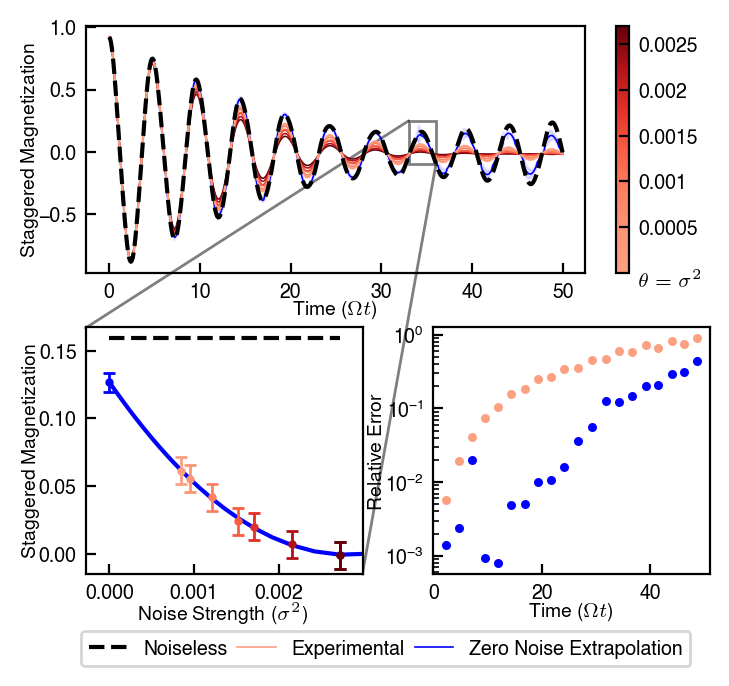

In [10]:
#ax_a.legend()
#ax_bi.legend()
fig.tight_layout(pad=0.01, h_pad=0.2, w_pad=0.2)
ax_a.legend(
    loc='upper center',  # Anchor point for the legend
    bbox_to_anchor=(0.6, -1.45),  # (x, y) coordinates relative to the axes
    ncol=3,  # Keep two columns
    borderaxespad=0,  # Padding between axes and legend
    columnspacing=0.5
)

x, y = -2.6, -3.38  # Position in data coordinates
#ax_z = ax_a.inset_axes([-2.7, -3.38, 30.5, 1.97],
#                  xlim  = (32, 34), ylim= (-0.05, .2))
ax_z = inset_axes(ax_a, 
                  width="100%",  # Reduce width to make inset smaller
                  height="100%", # Reduce height to match
                  bbox_to_anchor=(x, y, 30.5, 1.97),
                  bbox_transform=ax_a.transData,  # Use data coordinates
                  loc='center')
x_inset_range = (33, 36)
y_inset_range = (-.1, 0.25)
ax_z.set_xlim(x_inset_range)
ax_z.set_ylim(y_inset_range)
inset_zoom = ax_a.indicate_inset_zoom(ax_z, edgecolor="k", )
connector_lines = inset_zoom[1]  # The connector lines are returned as a tuple
connector_lines[0].set_visible(False)  # Hide the lower-left connector line
connector_lines[1].set_visible(True)   # Show the upper-left connector line
connector_lines[2].set_visible(True)   # Show the lower-right connector line
#Set the z order and transparaency of the connector line
connector_lines[2].set_zorder(-1)
connector_lines[3].set_visible(False)  # Hide the upper-right connector line
#Turn off all all the axes for ax_z:
ax_z.axis('off')
#Turn EVERYTHING OFF, leave only the connectors:
ax_z.set_xticks([])
ax_z.set_yticks([])
ax_z.set_xticklabels([])
ax_z.set_yticklabels([])
ax_z.set_xlabel("")
ax_z.set_ylabel("")
#ax_z.set_frame_on(False)

#fig.tight_layout()

#fig.savefig("Figure_2.pdf")#, bbox_inches='tight')
#fig.savefig("Figure_2.png", dpi=600)#, bbox_inches='tight', dpi=600)
#fig.savefig("Figure_2.svg")#, bbox_inches='tight')

fig

In [11]:
# fig = plt.figure()
# #Plotting other options for errors:


# import matplotlib as mpl

# columns = 1
# rows = 2
# #scol=(3+3/8) #single column width of PRL,
# #dcol=2*scol # double column,
# #size_col = [scol, dcol][columns-1]
# #size_row = [scol, dcol][rows-1]
# mmtoinch = 1/25.4
# scol = 88 * mmtoinch
# dcol = 180 * mmtoinch
# size_col = [scol, dcol][columns-1]
# if columns == 1:
#     size_row = scol*rows
# else:
#     size_row = dcol*rows

# fullwidth=6.3,
# from matplotlib import cm
# gr=(np.sqrt(5.0) - 1.0) / 2.0 #golden ratio,
# cm_subsection = np.linspace(0.2, 1.0, 5)
# Reds = [ cm.Reds(x) for x in cm_subsection ]
# mpl.rcParams.update({
#     "ytick.direction": "in",
#     "xtick.direction": "in",
#     "axes.labelpad": 0,
#     "font.size": 7,
#     "legend.frameon": True,
#     "figure.dpi":200,
#     "figure.figsize": [size_col, size_row * gr],
#     "font.family": "Helvetica",
#     #"axes.prop_cycle": cycler('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)
#     # "axes.prop_cycle": cycler('color', palettable.colorbrewer.sequential.Reds_9.mpl_colors[1:])
# })
# gs = gridspec.GridSpec(3,2)  # 2x2 grid
# ax_a = fig.add_subplot(gs[:2])
# ax_bi = fig.add_subplot(gs[2])
# ax_bii = fig.add_subplot(gs[3])


In [12]:
#Create a version that plots the rolling maximum error:
full_error = np.abs(stagmag_averaged[baseline_index] - stagmag_averaged[0])
full_error_ZNE = np.abs(ZNE_data - stagmag_averaged[0])
rolling_max_baseline = np.maximum.accumulate(full_error)
rolling_max_ZNE = np.maximum.accumulate(full_error_ZNE)
ax_bii.scatter(times, rolling_max_baseline, label="Baseline error", color=colors[indexes[0]], s=5)
ax_bii.scatter(times, rolling_max_ZNE, label="ZNE error", color="blue", s=5)
ax_bii.set_yscale("log")
ax_bii.set_ylim(0.001, 0.3)
ax_bii.set_ylabel(r'Maximum Error', usetex=1)
ax_bii.set_xlabel(r'Time ($\Omega t$)', usetex=1)
#ax_bii.legend()


Text(0.5, 83.06215908733321, 'Time ($\\Omega t$)')